## On the base of v0, try to get the angluar displacement based on the angular velocities.  --10-28-2025
Reference: Makarem et al. 2014, DOI: 10.1051/0004-6361/201323202

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from fun_barn import *
from matplotlib.animation import FuncAnimation

In [3]:
arm1, arm2 = 3.0, 3.0
pos_sep = 10.4
radius = pos_sep/np.sqrt(3)
rows = 4
cols = 4

N_fibers = int(rows * cols)

patrol_centers = generate_hex_grid(radius, rows, cols)
#patrol_centers

## set parameters for fiber positioner
platescale = 128.0  # JUST, unit: um/arcsec
##step_ang_size = 0.1               # the angular step size of positioner unit: arcsec (this is too small to be simulated)
step_ang_size = 0.1 *np.pi/180.0    # deg --> rad, set a large value, which is easy to simulate the change of angle

sigma_cb = 1.0                      # collision buffer size; unit: mm (naive guess for JUST, note that for SDSS V, it is 1.5 mm)
dis_md = (arm1+arm2)*np.sin(2*step_ang_size)       # distance of maximum displacement

dis_collision = 2*sigma_cb + dis_md
print("dis_collision:", dis_collision)

#step_dis_size = platescale * step_ang_size  # be careful of the unit of step_ang_size 

# Nstep_max = 1000/step_ang_size      # maximum number of steps allowed; 33 s configuration time with 30 deg/s arm rotation speed --> ~1000 deg 

# choices_list = [-1.0, 0.0, 1.0]
seed = 23
np.random.seed(seed)
# choice_0, choice_1 = np.random.choice(choices_list, size=2)
# print("choice_0, choice_1:", choice_0, choice_1)

dis_collision: 2.0209439084913425


In [4]:
targets_pos = []
for center_pos in patrol_centers:
    targets_pos.append(generate_random_point_in_circle(center_pos, radius=arm1 + arm2))

collide_ids = get_ids_targets_in_collison_dis(targets_pos, dis_collision)
while len(collide_ids)>0:
    for collide_id_pair in collide_ids:
        ## regenerate one target position
        patrol_id = collide_id_pair[0]
        targets_pos[patrol_id] = generate_random_point_in_circle(patrol_centers[patrol_id], radius=arm1 + arm2)

    collide_ids = get_ids_targets_in_collison_dis(targets_pos, dis_collision)

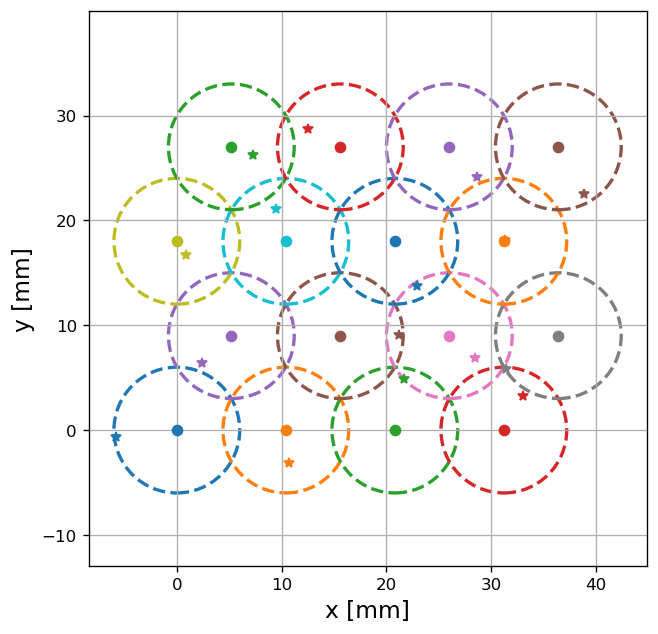

In [5]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
for i, xy in enumerate(patrol_centers):
    ax.plot(xy[0], xy[1], 'o', color=f'C{i}')
    ax.plot(targets_pos[i][0], targets_pos[i][1], '*',color=f'C{i}')
    circle = plt.Circle(xy, arm1+arm2, color=f'C{i}', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)
ax.axis('equal')

ax.set_xlabel("x [mm]", fontsize=14)
ax.set_ylabel("y [mm]", fontsize=14)
plt.grid()

In [6]:
## for test, reference from Table 3.
d_l = 4.0   # unit: mm
d_s = 2.0 

#lambda_1 = 1.0
lambda_2 = 0.2
lambda_1 = 18*0.8 * lambda_2

## construct kdTree of fibers
patrol_tree = KDTree(patrol_centers)

In [7]:
theta = np.zeros(N_fibers, dtype=float)
phi = np.zeros(N_fibers, dtype=float)
# pos_fibers = np.zeros((N_fibers, 2))
# for i, xy_patrol in enumerate(patrol_centers):
#     pos_fibers[i, :] = fiber_pos_thetaphi2xy(xy_patrol, theta, phi, arm1, arm2)
pos_fibers = fiber_pos_thetaphi2xy(patrol_centers, theta, phi, arm1, arm2)
print(pos_fibers)

[[0.00000000e+00 3.67394040e-16]
 [1.04000000e+01 3.67394040e-16]
 [2.08000000e+01 3.67394040e-16]
 [3.12000000e+01 3.67394040e-16]
 [5.20000000e+00 9.00666420e+00]
 [1.56000000e+01 9.00666420e+00]
 [2.60000000e+01 9.00666420e+00]
 [3.64000000e+01 9.00666420e+00]
 [0.00000000e+00 1.80133284e+01]
 [1.04000000e+01 1.80133284e+01]
 [2.08000000e+01 1.80133284e+01]
 [3.12000000e+01 1.80133284e+01]
 [5.20000000e+00 2.70199926e+01]
 [1.56000000e+01 2.70199926e+01]
 [2.60000000e+01 2.70199926e+01]
 [3.64000000e+01 2.70199926e+01]]


In [8]:
Nsteps = 1000
angvel_const = 0.10472  # 1 RPM to rad/s
t_step = 0.01           # unit: s

theta_list = []
phi_list = []

theta_1 = np.zeros(N_fibers, np.float32)
phi_1 = np.zeros(N_fibers, np.float32)
fiber_pos1 = fiber_pos_thetaphi2xy(patrol_centers, theta_1, phi_1, arm1, arm2)
theta_list.append(theta_1)
phi_list.append(phi_1)

psi_1 = cal_decen_navigation_fun(patrol_centers, patrol_tree, fiber_pos1, targets_pos, d_l, d_s, lambda_1, lambda_2, arm1, arm2, N_fibers)

delta_theta = np.ones(N_fibers)*0.1 * np.pi/180.0  # step size 0.1 deg, iniital guess
delta_phi = np.ones(N_fibers)*0.1 * np.pi/180.0

# sign_dtheta = np.ones(N_fibers, np.float32)
# sign_dphi = np.ones(N_fibers, np.float32)

wmax_list = []
t0 = time.time()
for i in range(Nsteps):
    theta_2 = theta_1 + delta_theta
    phi_2 = phi_1 + delta_phi
    fiber_pos2 = fiber_pos_thetaphi2xy(patrol_centers, theta_2, phi_2, arm1, arm2)

    psi_2 = cal_decen_navigation_fun(patrol_centers, patrol_tree, fiber_pos2, targets_pos, d_l, d_s, lambda_1, lambda_2,  arm1, arm2, N_fibers)
    #print("psi_2:", psi_2)
    theta_mean = (theta_1 + theta_2)/2.0
    phi_mean = (phi_1 + phi_2)/2.0
    angular_vel = cal_fiber_angular_vel(psi_1, psi_2, fiber_pos1, fiber_pos2, theta_mean, phi_mean, arm1, arm2)
    #print("angular_vel:", angular_vel)
    wmax_list.append(np.max(np.abs(angular_vel)))
    
    delta_theta = angular_vel[:, 0] * t_step * angvel_const
    delta_phi   = angular_vel[:, 1] * t_step * angvel_const
    #print(delta_theta, delta_phi)

    theta_1 = theta_2
    phi_1 = phi_2
    fiber_pos1 = fiber_pos2
    psi_1 = psi_2
    
    theta_list.append(theta_1)
    phi_list.append(phi_1)
    
t1 = time.time()
print("Running time (s):", t1-t0)

Running time (s): 1.1133849620819092


In [9]:
## how to relate RPM with lambda_1 and lambda_2?
wmax = np.max(wmax_list)
print(wmax)
print(20/(wmax * 60/(2*np.pi)))

5246.7468248611385
0.0003991797531508729


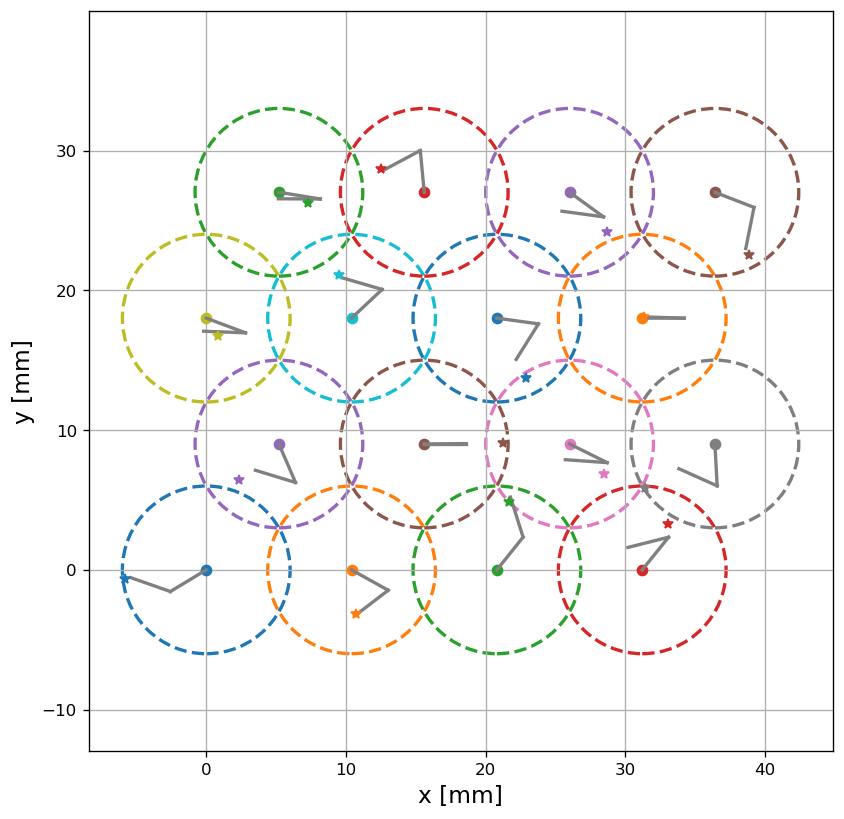

In [10]:
arm1_pos = get_arm1_endpoint(patrol_centers, theta_list[-1], arm1)
fiber_pos = fiber_pos_thetaphi2xy(patrol_centers, theta_list[-1], phi_list[-1], arm1, arm2)

fig, ax = plt.subplots(figsize=(8, 8), dpi=120)
for i, xy in enumerate(patrol_centers):
    ax.plot(xy[0], xy[1], 'o', color=f'C{i}')
    ax.plot([xy[0], arm1_pos[i, 0]], [xy[1], arm1_pos[i, 1]], ls='-', color='gray', lw=2.0)
    ax.plot([arm1_pos[i, 0], fiber_pos[i, 0]], [arm1_pos[i, 1], fiber_pos[i, 1]], ls='-', color='gray', lw=2.0)
    ax.plot(targets_pos[i][0], targets_pos[i][1], '*',color=f'C{i}')
    circle = plt.Circle(xy, arm1+arm2, color=f'C{i}', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)
ax.axis('equal')

ax.set_xlabel("x [mm]", fontsize=14)
ax.set_ylabel("y [mm]", fontsize=14)
plt.grid()

In [11]:
## animate the motions of fiber arms
arm1_pos_list = []
fiber_pos_list = []
for theta, phi in zip(theta_list, phi_list):
    arm1_pos = get_arm1_endpoint(patrol_centers, theta, arm1)
    fiber_pos = fiber_pos_thetaphi2xy(patrol_centers, theta, phi, arm1, arm2)
    arm1_pos_list.append(arm1_pos)
    fiber_pos_list.append(fiber_pos)
    
arm1_pos_list = np.array(arm1_pos_list)
fiber_pos_list = np.array(fiber_pos_list)
print(arm1_pos_list[0])

[[ 3.         0.       ]
 [13.4        0.       ]
 [23.8        0.       ]
 [34.2        0.       ]
 [ 8.2        9.0066642]
 [18.6        9.0066642]
 [29.         9.0066642]
 [39.4        9.0066642]
 [ 3.        18.0133284]
 [13.4       18.0133284]
 [23.8       18.0133284]
 [34.2       18.0133284]
 [ 8.2       27.0199926]
 [18.6       27.0199926]
 [29.        27.0199926]
 [39.4       27.0199926]]


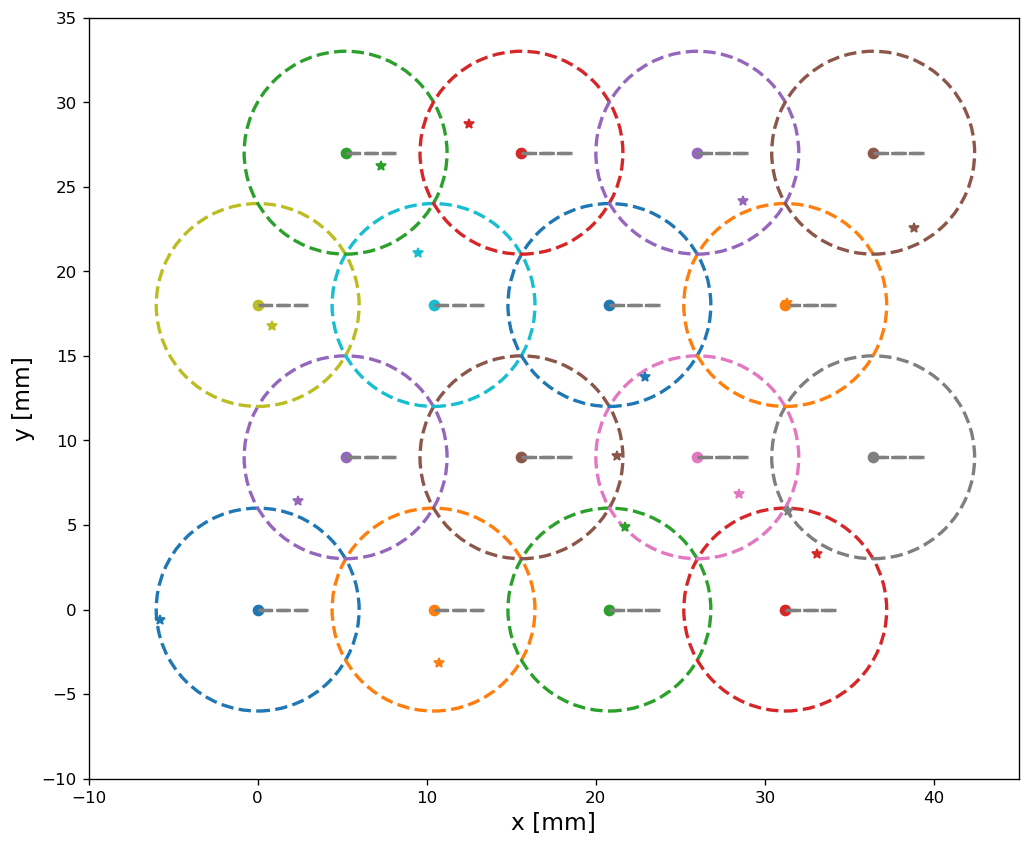

CPU times: user 1min 29s, sys: 8.36 s, total: 1min 37s
Wall time: 1min 37s


In [12]:
%%time
# 创建图形对象
fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
ax.set_xlim(-10, 45)
ax.set_ylim(-10, 35)

# 绘制静态元素（巡逻中心、连接线等）
for i in range(N_fibers):
    xy = patrol_centers[i]
    ax.plot(xy[0], xy[1], 'o', color=f'C{i}')
    
    # 修正索引逻辑（使用当前帧数据）
    #if i < len(arm1_pos_list):
    ax.plot([xy[0], arm1_pos_list[0,i,0]], [xy[1], arm1_pos_list[0,i,1]], 
            ls='--', color='gray', lw=2.0)
    
    #if i < len(fiber_pos_list):
    ax.plot([arm1_pos_list[0,i,0], fiber_pos_list[0,i,0]], 
            [arm1_pos_list[0,i,1], fiber_pos_list[0,i,1]], 
            ls='--', color='gray', lw=2.0)
    
    ax.plot(targets_pos[i][0], targets_pos[i][1], '*', color=f'C{i}')
    circle = plt.Circle(xy, arm1+arm2, color=f'C{i}', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)

ax.set_aspect('equal')
ax.set_xlabel("x [mm]", fontsize=14)
ax.set_ylabel("y [mm]", fontsize=14)

# 初始化绘图元素（关键修改）
rods1 = [ax.plot([], [], 'k-', lw=2)[0] for _ in range(N_fibers)]
rods2 = [ax.plot([], [], 'k-', lw=2)[0] for _ in range(N_fibers)]
bobs1 = [ax.plot([], [], 'o', color='gray', markersize=1)[0] for _ in range(N_fibers)]
bobs2 = [ax.plot([], [], 'ko', markersize=4)[0] for _ in range(N_fibers)]

# 动画函数（关键修改）
def animate(i):
    for idx in range(N_fibers):
        # 修正数据索引方式
        x1, y1 = arm1_pos_list[i, idx, 0], arm1_pos_list[i, idx, 1]
        x2, y2 = fiber_pos_list[i, idx, 0], fiber_pos_list[i, idx, 1]
        
        base_x, base_y = patrol_centers[idx]
        rods1[idx].set_data([base_x, x1], [base_y, y1])
        rods2[idx].set_data([x1, x2], [y1, y2])
        bobs1[idx].set_data([x1], [y1])
        bobs2[idx].set_data([x2], [y2])
    return rods1 + rods2 + bobs1 + bobs2
    return rods1 + rods2 


def init():
    for rod in rods1 + rods2:
        rod.set_data([], [])
    for bob in bobs1 + bobs2:
        bob.set_data([], [])
    return rods1 + rods2 + bobs1 + bobs2

# 创建动画（关键参数修正）
ani = FuncAnimation(fig, animate, frames=Nsteps, init_func=init,
                    interval=50, blit=True, repeat=False)

plt.show()

# 保存动画（兼容性方案）
ani.save('fiber_motion_v1.gif', writer='pillow', fps=30)

In [12]:
# Set up plot
# fig, ax = plt.subplots(figsize=(8, 8), dpi=120)
# for i, xy in enumerate(patrol_centers):
#     ax.plot(xy[0], xy[1], 'o', color=f'C{i}')
#     ax.plot([xy[0], arm1_pos[i, 0]], [xy[1], arm1_pos[i, 1]], ls='-', color='gray', lw=2.0)
#     ax.plot([arm1_pos[i, 0], fiber_pos[i, 0]], [arm1_pos[i, 1], fiber_pos[i, 1]], ls='-', color='gray', lw=2.0)
#     ax.plot(targets_pos[i][0], targets_pos[i][1], '*',color=f'C{i}')
#     circle = plt.Circle(xy, arm1+arm2, color=f'C{i}', fill=False, linestyle='--', linewidth=2)
#     ax.add_patch(circle)
    

# ax.set_aspect('equal')
# #ax.set_title("Simple Pendulum Animation")

# positions = []
# for arm1_pos, fiber_pos in zip(arm1_pos_list, fiber_pos_list):
#     x1 = arm1_pos[:, 0]
#     y1 = arm1_pos[:, 1]
#     x2 = fiber_pos[:, 0]
#     y2 = fiber_pos[:, 1]
#     positions.append((x1, y1, x2, y2))

# # 绘图元素
# rods1 = []
# rods2 = []
# bobs1 = []
# bobs2 = []

# for _ in range(N_fibers):
#     rod1, = ax.plot([], [], 'k-', lw=2)
#     rod2, = ax.plot([], [], 'k-', lw=2)
#     bob1, = ax.plot([], [], 'ro', markersize=10)
#     bob2, = ax.plot([], [], 'bo', markersize=10)
#     rods1.append(rod1)
#     rods2.append(rod2)
#     bobs1.append(bob1)
#     bobs2.append(bob2)

# # 初始化函数
# def init():
#     artists = []
#     for i in range(N_fibers):
#         rods1[i].set_data([], [])
#         rods2[i].set_data([], [])
#         bobs1[i].set_data([], [])
#         bobs2[i].set_data([], [])
#         artists += [rods1[i], rods2[i], bobs1[i], bobs2[i]]
#     return artists

# def animate(i):
#     artists = []
#     for idx, (x1, y1, x2, y2) in enumerate(positions):
#         rods1[idx].set_data([0, x1[i]], [0, y1[i]])
#         rods2[idx].set_data([x1[i], x2[i]], [y1[i], y2[i]])
#         bobs1[idx].set_data([x1[i]], [y1[i]])
#         bobs2[idx].set_data([x2[i]], [y2[i]])
#         artists += [rods1[idx], rods2[idx], bobs1[idx], bobs2[idx]]
#     return artists


# # 创建动画
# ani = FuncAnimation(fig, animate, frames=Nsteps, init_func=init,
#                     interval=1000, blit=True, repeat=False)

# plt.show()

# # 保存动画（需安装FFmpeg）
# ani.save('fiber_motion.gif', writer='ffmpeg', fps=30)